In [1]:
#Variational method using the VQC algorithm.
#Reference - “Supervised learning with quantum enhanced feature spaces,” arXiv: 1804.11326
import numpy as np

from qiskit import BasicAer
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import VQC
from qiskit.aqua.components.optimizers import SPSA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name

seed = 10599
aqua_globals.random_seed = seed

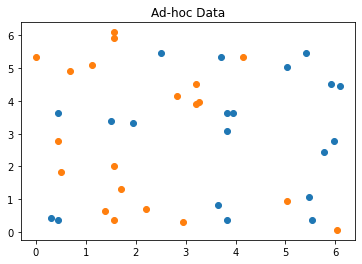

{'A': 0, 'B': 1}


In [2]:
from qiskit.ml.datasets import ad_hoc_data, sample_ad_hoc_data

feature_dim = 2
sample_total, training_input, test_input, class_labels = ad_hoc_data(
    training_size=20,
    test_size=10,
    n=feature_dim,
    gap=0.3,
    plot_data=True
)
extra_test_data = sample_ad_hoc_data(sample_total, 10, n=feature_dim)
datapoints, class_to_label = split_dataset_to_data_and_labels(extra_test_data)
print(class_to_label)

In [3]:
#We setup the VQC algorithm to do a classification. 

#We use the ZZFeatureMap data encoding circuit from the Qiskit circuit library
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)

#As the qasm_simulator has shot noise we choose to use SPSA which is designed to perform under noisy conditions.
optimizer = SPSA(maxiter=40, c0=4.0, skip_calibration=True)

#Since this is a variational algorithm, we need a variational form, i.e. parameterized circuit, 
#whose parameters can be varied by an optimizer when computing VQC’s cost function. 
#For this we choose TwoLocal from the Qiskit circuit library. 
var_form = TwoLocal(feature_dim, ['ry', 'rz'], 'cz', reps=3)
vqc = VQC(optimizer, feature_map, var_form, training_input, test_input, datapoints[0])

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = vqc.run(quantum_instance)

print(f'Testing success ratio: {result["testing_accuracy"]}')
print()
print('Prediction from datapoints set:')
print(f'  ground truth: {map_label_to_class_name(datapoints[1], vqc.label_to_class)}')
print(f'  prediction:   {result["predicted_classes"]}')
predicted_labels = result["predicted_labels"]
print(f'  success rate: {100*np.count_nonzero(predicted_labels == datapoints[1])/len(predicted_labels)}%')

Testing success ratio: 0.9

Prediction from datapoints set:
  ground truth: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  prediction:   ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  success rate: 100.0%


In [4]:
#Now VQC, as well as QSVM, have train, test and predict methods. 
#The run method, as used above, will call these in turn based on whatever data was supplied to the algorithm. 
#But the methods called directly to say train a model and then do predict. 
more_test_data = sample_ad_hoc_data(sample_total, 10, n=feature_dim)
more_datapoints, _ = split_dataset_to_data_and_labels(more_test_data)

#Since the vqc instance has already been trained, 
#We can predict another set of sample datapoints by directly calling predict.
predicted_probabilities, predicted_labels = vqc.predict(datapoints[0])

print('Prediction from more_datapoints set:')
print(f'  ground truth: {map_label_to_class_name(more_datapoints[1], vqc.label_to_class)}')
print(f'  prediction:   {map_label_to_class_name(predicted_labels, vqc.label_to_class)}')
print(f'  success rate: {100*np.count_nonzero(predicted_labels == more_datapoints[1])/len(predicted_labels)}%')

#Note: Qiskit classifier algorithms can save_model after training and also load_model that had been previously saved.

Prediction from more_datapoints set:
  ground truth: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  prediction:   ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  success rate: 100.0%
